# DSAI HW1 Peak Load Forecasting

### 目標

- 利用 2017 年到 2018 年的電力相關資訊預測未來 2019/04/02 - 2019/04/08 的電力尖峰負載。

### Import Data

- 使用到的檔案包含：

    - Power2017-2018.csv - 2017/01/01 到 2018/11/30 的所有電力資料
    
    - Power2018-2019.csv - 2018/01/01 到 2019/02/28 的所有電力資料
    
    - Taipei_temperature.csv - 2017/01/01 到 2019/02/28 台北每日的平均氣溫、最高氣溫與最低氣溫
    
    - Kaohsiung_temperature.csv -  2017/01/01 到 2019/02/28 高雄每日的平均氣溫、最高氣溫與最低氣溫
    
    - Future_temperature.csv - 2019/04/02 到 2019/04/08 中央氣象局預測的台北與高雄每日的最高氣溫與最低氣溫

In [1]:
import codecs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

date_parser = lambda x: pd.datetime.strptime(x, "%Y%m%d")
date_parser2 = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")

with codecs.open('Data/Power2017-2018.csv','r','utf-8-sig') as f:
    data2017 = pd.read_csv(f, encoding='utf-8', parse_dates=['日期'], date_parser=date_parser, index_col=['日期'])
    f.close()

with codecs.open('Data/Power2018-2019.csv','r','utf-8-sig') as f:
    data2018 = pd.read_csv(f, encoding='utf-8', parse_dates=['日期'], date_parser=date_parser, index_col=['日期'])
    f.close()
    
with open('Data/Taipei_temperature.csv','r') as f:
    taipei_temperature = pd.read_csv(f, encoding='utf-8', parse_dates=True, date_parser=date_parser2, index_col=0)
    f.close()
    
with open('Data/Kaohsiung_temperature.csv','r') as f:
    Kaohsiung_temperature = pd.read_csv(f, encoding='utf-8', parse_dates=True, date_parser=date_parser2, index_col=0)
    f.close()

with open('Data/Future_temperature.csv','r') as f:
    Future_temperature = pd.read_csv(f, encoding='utf-8', parse_dates=True, date_parser=date_parser2, index_col=0)
    f.close()

### Data Exploring

- 取出只有單獨年份的尖峰負載資料，並且畫出箱型圖來簡單的觀察資料分布。

- 可以發現在 2018 年資料分布得比較密集，造成了最低的幾筆數據被判定為異常值，而除了第三四分位數之外，整體數據也較 2017 年有些微的增加。

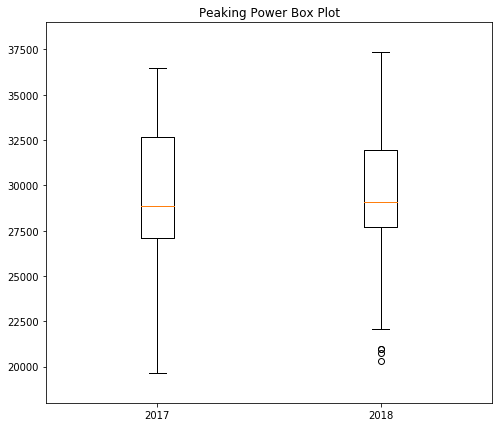

In [2]:
peaking_power2017 = data2017['2017-01-01':'2017-12-31'][data2017.columns[1]]
peaking_power2018 = data2018['2018-01-01':'2018-12-31'][data2018.columns[1]]

fig, ax = plt.subplots(figsize=(8, 7))
ax.boxplot([peaking_power2017, peaking_power2018], labels=[2017, 2018])
ax.set_title('Peaking Power Box Plot')
ax.set_ylim([18000, 39000])
plt.show()

- 接這我們分別畫出 2017 年與 2018 年中，尖峰負載隨著時間變化的趨勢圖。

- 可以發現兩年的尖峰負載都有明顯的在夏天較高的趨勢，因此氣溫或許是非常值得納入考量的重要因素。此外兩年的變化趨勢也有一些差異，2018 年較早的在六月左右就達到高峰，2017 年則較晚達到並且一直延續到十月都一直處在高峰。

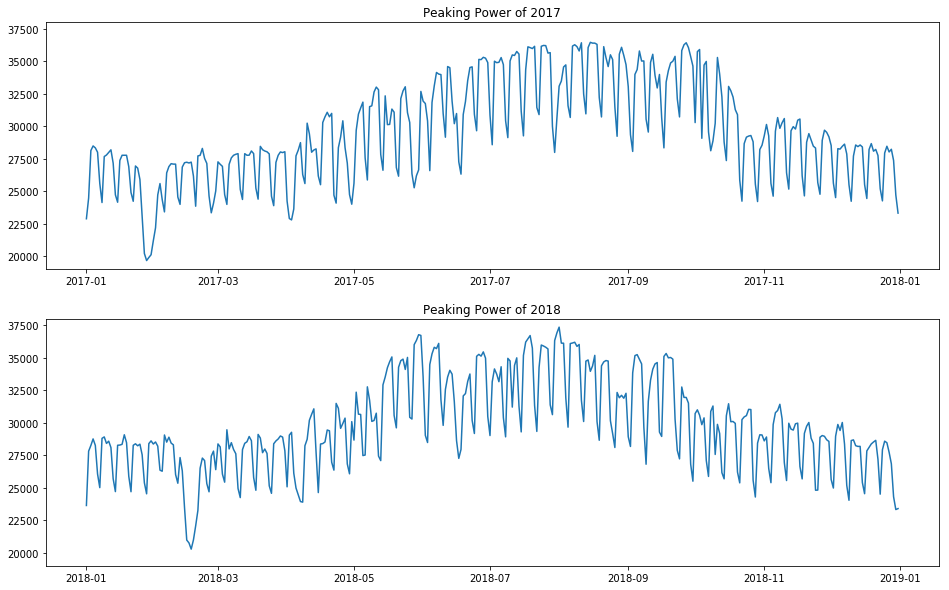

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

ax = axes[0] 
ax.plot(peaking_power2017)
ax.set_title('Peaking Power of 2017')
ax.set_ylim([19000, 38000])

ax = axes[1]
ax.plot(peaking_power2018)
ax.set_title('Peaking Power of 2018')
ax.set_ylim([19000, 38000])

plt.show()

- 可以發現數值具有週期性的變化且大致與星期相符，因此嘗試將所有資料以星期一到星期天作為分類，看看是否具有可觀察到的趨勢。

- 透過箱型圖我們可以發現，星期一到星期五的數據分布較為相近，中位數幾乎都維持在 30000MW 左右，不過星期一整體而言略低一些，而假日的星期六與星期天則有明顯程度不同的下降趨勢，可以想見之後的分析會需要以星期天數或假期與否作為區分。

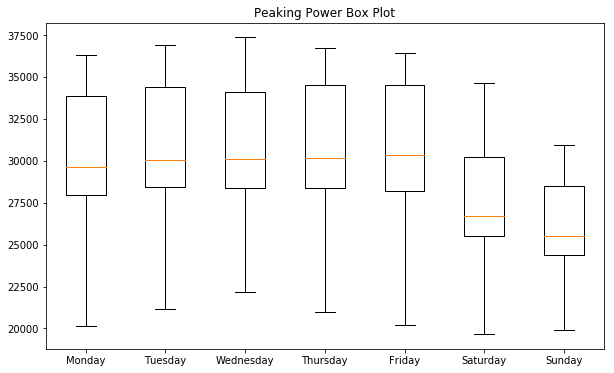

In [4]:
peaking_power = pd.concat([peaking_power2017, peaking_power2018])
peaking_power_week = [peaking_power[peaking_power.index.weekday==i] for i in range(7)]
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(peaking_power_week, labels=weekdays)
ax.set_title('Peaking Power Box Plot')
plt.show()

- 有鑑於我們發現了假期對於尖峰負載的影響，而我們所要預測的期間又剛好包含了清明連假，因此畫出 2017 年與 2018 年清明連假時尖峰負載的詳細趨勢來分析似乎是有必要的。

- 下面兩張圖分別用紅點標示出了 2017 年與 2018 年清明連假的時間點，可以發現清明連假期間的尖峰負載是明顯下降的，因此之後可能就要以假期的尖峰負載來做預測。

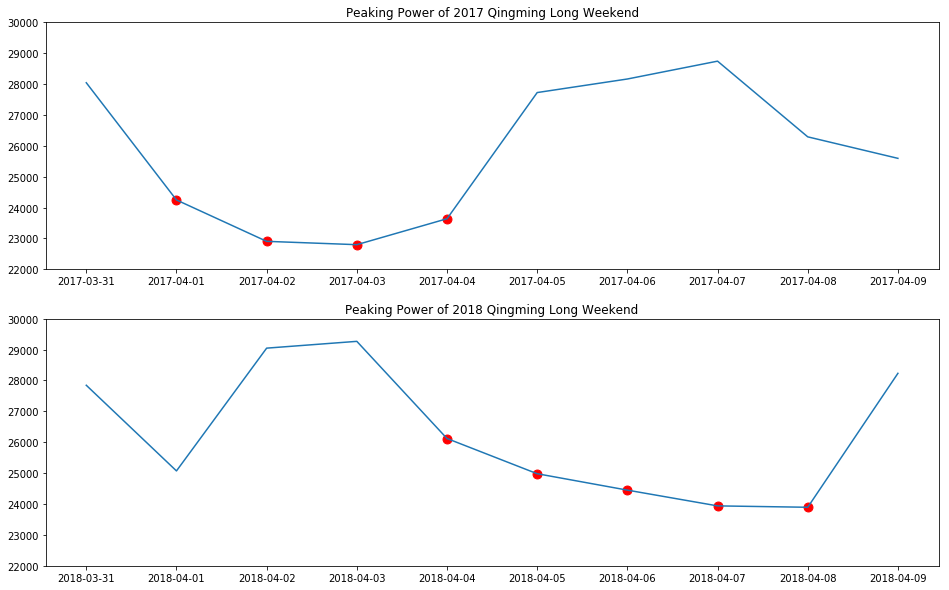

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

ax = axes[0] 
ax.plot(peaking_power['2017-03-31':'2017-04-09'])
ax.scatter(pd.date_range('2017-04-01', '2017-04-04'), peaking_power['2017-04-01':'2017-04-04'], s=80, c='red')
ax.set_title('Peaking Power of 2017 Qingming Long Weekend')
ax.set_ylim([22000, 30000])

ax = axes[1]
ax.plot(peaking_power['2018-03-31':'2018-04-09'])
ax.scatter(pd.date_range('2018-04-04', '2018-04-08'), peaking_power['2018-04-04':'2018-04-08'], s=80, c='red')
ax.set_title('Peaking Power of 2018 Qingming Long Weekend')
ax.set_ylim([22000, 30000])

plt.show()

### Weather Data

- 接著加入收集到的台北與高雄氣溫，並試著計算尖峰負載與各種氣溫資料之間的相關性。

- 可以發現氣溫與尖峰負載的確有著很高的相關性，比較出人意料的是，與尖峰負載最相關的反而是當日最低氣溫，而台北的相關性似乎也明顯大於高雄的，這些發現也許可以當成未來預測時的一個方向。

In [6]:
mean_temperature = (taipei_temperature['Temperature'] + Kaohsiung_temperature['Temperature']) / 2
mean_max_temperature = (taipei_temperature['T Max'] + Kaohsiung_temperature['T Max']) / 2
mean_min_temperature = (taipei_temperature['T Min'] + Kaohsiung_temperature['T Min']) / 2

print('Temperature:')
print('  Taipei\t', peaking_power.corr(taipei_temperature['Temperature']))
print('  Kaohsiung\t', peaking_power.corr(Kaohsiung_temperature['Temperature']))
print('  Mean\t\t', peaking_power.corr(mean_temperature))
print('\nMax Temperature:')
print('  Taipei \t', peaking_power.corr(taipei_temperature['T Max']))
print('  Kaohsiung\t', peaking_power.corr(Kaohsiung_temperature['T Max']))
print('  Mean\t\t', peaking_power.corr(mean_max_temperature))
print('\nMin Temperature:')
print('  Taipei \t', peaking_power.corr(taipei_temperature['T Min']))
print('  Kaohsiung\t', peaking_power.corr(Kaohsiung_temperature['T Min']))
print('  Mean\t\t', peaking_power.corr(mean_min_temperature))

Temperature:
  Taipei	 0.7447941425096896
  Kaohsiung	 0.69229648022129
  Mean		 0.7374494289021862

Max Temperature:
  Taipei 	 0.701026906339014
  Kaohsiung	 0.651437549559848
  Mean		 0.7085051808045325

Min Temperature:
  Taipei 	 0.751502067748771
  Kaohsiung	 0.6962421890775282
  Mean		 0.7409504262912289


- 接著我們試著將台北與高雄的當日最低氣溫平均之後與尖峰負載放在同一張圖作比較。

- 儘管前面已經知道了兩者有著很大的關係，但畫出時間趨勢後還是可以看到具有驚人的一致性。

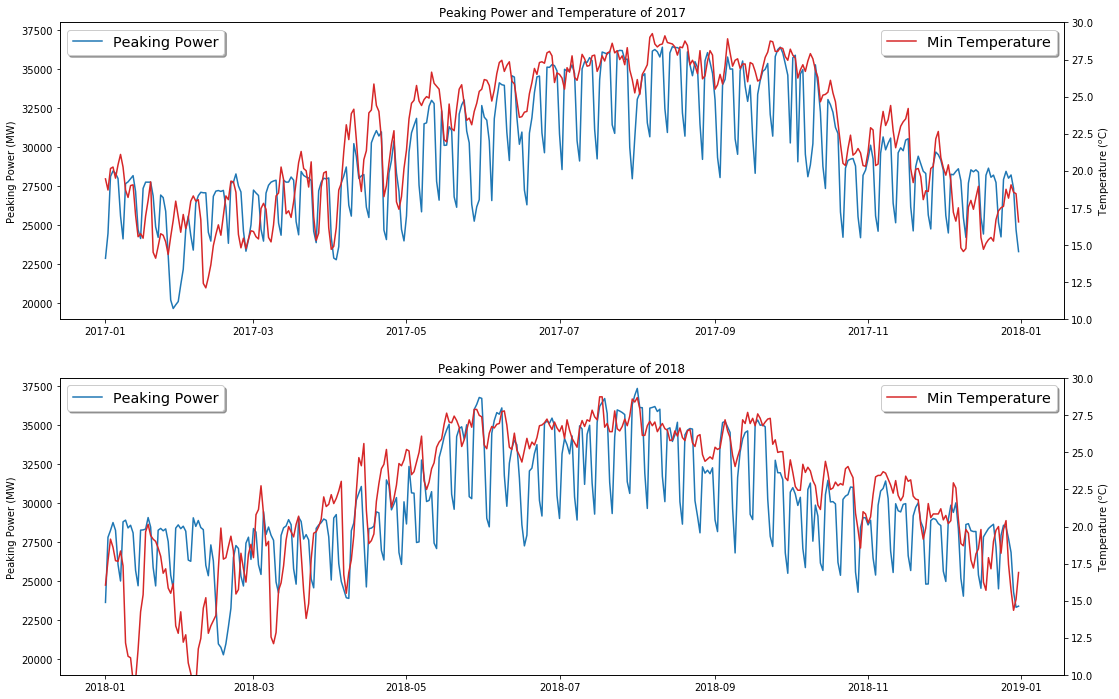

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(18, 12))
temperature2017 = (taipei_temperature['2017']['T Min'] + Kaohsiung_temperature['2017']['T Min']) / 2
temperature2018 = (taipei_temperature['2018']['T Min'] + Kaohsiung_temperature['2018']['T Min']) / 2

ax = axes[0] 
ax.plot(peaking_power2017, label='Peaking Power')
ax.set_title('Peaking Power and Temperature of 2017')
ax.set_ylabel('Peaking Power (MW)')
ax.set_ylim([19000, 38000])
ax.legend(loc='upper left', shadow=True, fontsize='x-large')

ax2 = ax.twinx()
#ax2.plot(taipei_temperature['2017']['T Max'], color='tab:orange', label='Taipei Temperature')
ax2.plot(temperature2017, color='tab:red', label='Min Temperature')
ax2.set_ylabel('Temperature ($^o$C)')
ax2.set_ylim([10, 30])
ax2.legend(loc='upper right', shadow=True, fontsize='x-large')
ax = axes[1]
ax.plot(peaking_power2018, label='Peaking Power')
ax.set_title('Peaking Power and Temperature of 2018')
ax.set_ylabel('Peaking Power (MW)')
ax.set_ylim([19000, 38000])
ax.legend(loc='upper left', shadow=True, fontsize='x-large')

ax2 = ax.twinx()
#ax2.plot(taipei_temperature['2018']['T Max'], color='tab:orange', label='Taipei Temperature')
ax2.plot(temperature2018, color='tab:red', label='Min Temperature')
ax2.set_ylabel('Temperature ($^o$C)')
ax2.set_ylim([10, 30])
ax2.legend(loc='upper right', shadow=True, fontsize='x-large')

plt.show()

### Data Modeling

- 依據之前發現的在一星期中有不同分布的結果，並結合氣溫與尖峰負載的高度相關性，我們就可以試圖建立模型來進行之後的預測。

- 首先我們先將 2017 年與 2018 年的所有資料按照星期一到星期日分成 7 類，並分別進行二次回歸來建立 7 個模型。

- 由於整年度的各個假期會在 7 個分類中造成許多極端值，因此選用了 RANSAC 來進行回歸，以下分別畫出 7 個分類的分布與預測的回歸線。

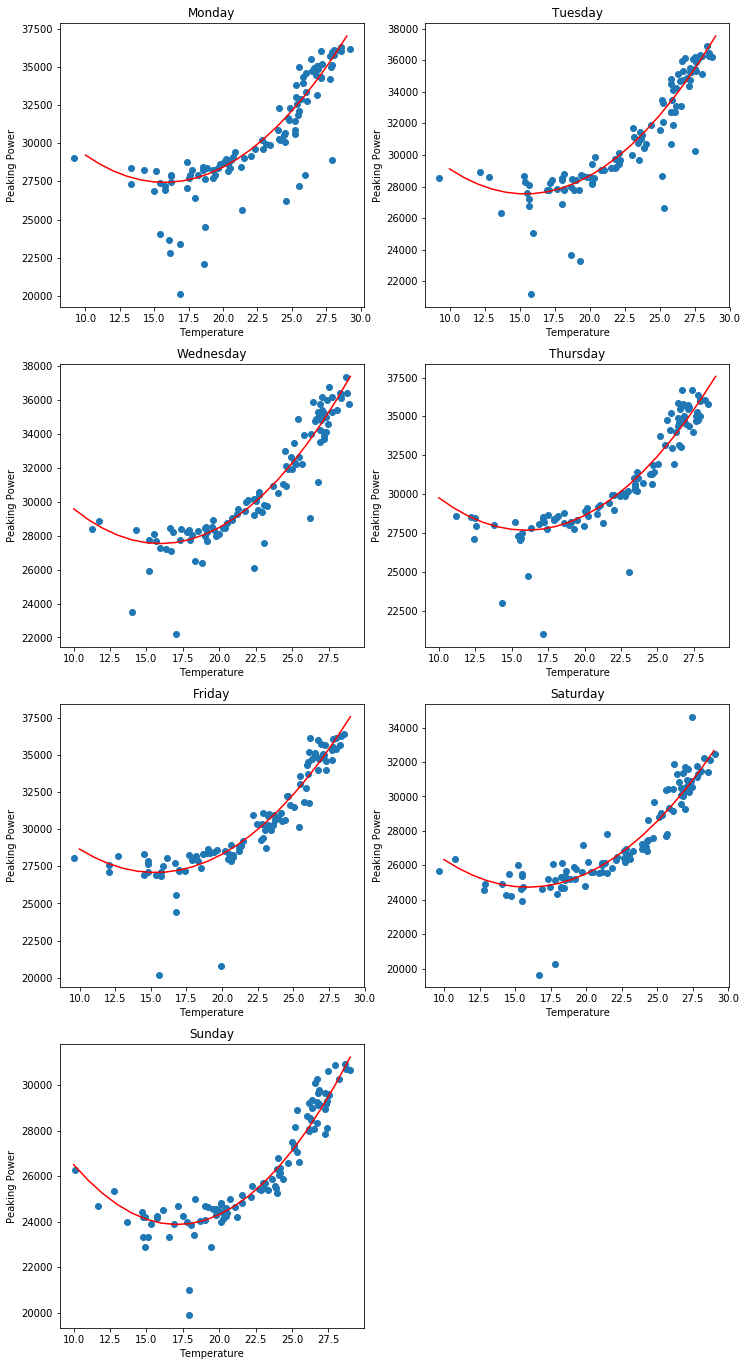

In [8]:
temperature = pd.concat([temperature2017, temperature2018])
temperature_group = [temperature[temperature.index.weekday==i] for i in range(7)]
peaking_power_group = [peaking_power[peaking_power.index.weekday==i] for i in range(7)]
group_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axes = plt.subplots(4, 2, figsize=(12, 24))
regression = [None] * 7
for i in range(7):
    regression[i] = make_pipeline(PolynomialFeatures(2), RANSACRegressor(random_state=42))
    regression[i].fit(np.array(temperature_group[i]).reshape(-1, 1), peaking_power_group[i])
    X = np.arange(10, 30)
    y = regression[i].predict(X.reshape(-1, 1))
    ax = axes.reshape(-1)[i]
    ax.scatter(temperature_group[i], peaking_power_group[i])
    ax.plot(X, y, c='red')
    ax.set_title(group_name[i])
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Peaking Power')
fig.delaxes(axes[3,1])
plt.show()

### Model Validation

- 在我們所擁有的資料中剛好有一些資料是我們不曾使用的，像是 2019 年一月份的資料，這就剛好可以用來驗證我們的模型在預測上的準確率。

- 以下利用了上面生成的 7 個模型來預測 2019 年一月份的尖峰負載，並顯示最後預測結果的 RMSE 以及趨勢圖。

RMSE: 879.7523359415018


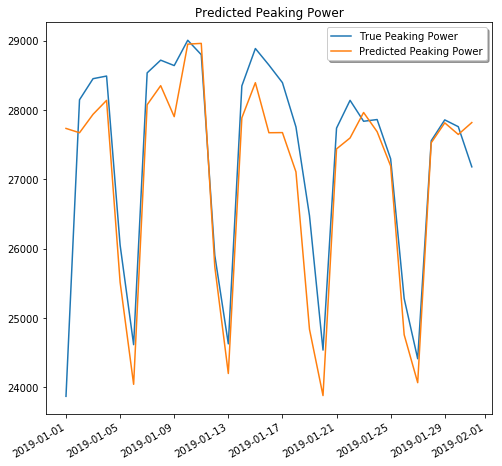

In [9]:
peaking_power2019 = data2018['2019-01'][data2018.columns[1]]
peaking_power2019_group = [peaking_power2019[peaking_power2019.index.weekday==i] for i in range(7)]
temperature2019 = (taipei_temperature['2019-01']['T Min'] + Kaohsiung_temperature['2019-01']['T Min']) / 2
temperature2019_group = [temperature2019[temperature2019.index.weekday==i] for i in range(7)]

y_true = []
y_pred = []
for day in pd.date_range('2019-01-01', '2019-01-31'):
    y = regression[day.weekday()].predict(np.array(temperature2019[day]).reshape(-1, 1))
    y_true.append(peaking_power2019[day])
    y_pred.append(y) 

print('RMSE:', np.sqrt(mean_squared_error(y_true, y_pred)))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(pd.date_range('2019-01-01', '2019-01-31'), y_true, label='True Peaking Power')
ax.plot(pd.date_range('2019-01-01', '2019-01-31'), y_pred, label='Predicted Peaking Power')
ax.legend(loc='upper right', shadow=True, fontsize='medium')
ax.set_title('Predicted Peaking Power')
fig.autofmt_xdate()
plt.show()

### Predict Peaking Power

- 最後我們就可以利用我們的模型來預測 2019/04/02 - 2019/04/08 的電力尖峰負載了。

- 由於橫跨了清明連假，因此將假期第一天改用周六的模型預測，其餘放假的天數則都改用週日的模型來預測，最後就是預測出來的結果了。

In [10]:
predict_weekdays = [1, 2, 5, 6, 6, 6, 0]
predict_temperature = (Future_temperature['Taipei T Min'] + Future_temperature['Kaohsiung T Min']) / 2
predict_days = predict_temperature.index
predicted_peaking_Power = pd.Series([0] * 7, index=predict_days)
for i in range(7):
    X = np.array(predict_temperature[predict_days[i]]).reshape(-1, 1)
    predicted_peaking_Power[predict_days[i]] = regression[predict_weekdays[i]].predict(X)
print(predicted_peaking_Power)

2018-04-02    28229
2018-04-03    28272
2018-04-04    25340
2018-04-05    24313
2018-04-06    24476
2018-04-07    24666
2018-04-08    28953
dtype: int64
